In [2]:
import os
import pandas as pd
import numpy as np
import statistics
import math

from keras.layers import Input, Dense
from keras.models import Model,Sequential

from sklearn import metrics
from itertools import islice

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = (8,6)

Using TensorFlow backend.


In [9]:
datapath_1000 = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
datapath_10000 = "G:\\Dev\\Data\\10000\\GNPS Python Master\\Final Data.txt"
datapath_1000_triangle = "G:\\Dev\\Data\\1000_Triangle\\GNPS Python Master\\Final Data.txt"
datapath_10000_triangle = "G:\\Dev\\Data\\10000_Triangle\\GNPS Python Master\\Final Data.txt"

# Final fingerprints is the same across all bin strategies
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"

experiment_path = "G:\\Dev\\Data\\binning_strategies_experiment\\"

In [4]:
def load_master_file(path, number_of_bins = 1000):
    MAX_MASS = 1000
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range(number_of_bins), dtype=float)
    
    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1])-1] = float(row[2])
    
    return intensities


def load_fingerprints_master(path, number_of_rows=0):
    BITS = 320  # Total number of bits in fingerprint

    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows) # skip header if its there
    fp_ids = np.unique(fp_all[:, 0]) # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    return fingerprints

def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names."
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names.",
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend

In [5]:
bins_1000 = load_master_file(datapath_1000, 1000)
bins_10000 = load_master_file(datapath_1000, 10000)
bins_1000_triangle = load_master_file(datapath_1000_triangle, 1000)
bins_10000_triangle = load_master_file(datapath_10000_triangle, 10000)

fingerprints = load_fingerprints_master(fingerprints_path)
for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
    if value < 10:
        fingerprints.drop(columns=[idx], inplace=True)

fingerprints.sort_index(inplace=True)
relevant_fingerprints = fingerprints.columns

In [6]:
def baseline_model(x_train_spectra, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=x_train_spectra.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return class_model

In [7]:
def compute_auc(indexes, true, pred):
    auc_scores = []
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values\n",
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.\n",
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.roc_auc_score(fp_true, fp_pred)
            auc_scores.append((index, score))
        else:
            auc_scores.append((index, 0.0))
            
    print("Compute AUC done")
    return auc_scores

def compute_f1(indexes, true, pred):
    f1_scores = []
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values",
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.",
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.f1_score(fp_true, fp_pred, average='micro')
            f1_scores.append((index, score))
        else:
            f1_scores.append((index, 0.0))
    print("Compute F1 done")
    return f1_scores

Baseline 1000

In [18]:
for i in range(0,10):
    print(i)
    epochs = 100
    
    train_path = experiment_path + "train_spec_exp_{}.pkl".format(i)
    validate_path = experiment_path + "validate_spec_exp_{}.pkl".format(i)
    test_path = experiment_path + "test_spec_exp_{}.pkl".format(i)
    auc_path = experiment_path + "baseline1000_exp_{}_aucs.csv".format(i)
    f1_path = experiment_path + "baseline1000_exp_{}_f1_scores.csv".format(i)
    
    train, validate, test = np.split(bins_1000.sample(frac=1), [int(.6*len(bins_1000)), int(.8*len(bins_1000))])

    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)

    train.to_pickle(train_path) 
    validate.to_pickle(validate_path) 
    test.to_pickle(test_path) 
    
    train_spectra = np.log(train.values+1)
    validate_spectra = np.log(validate.values+1)
    test_spectra = np.log(test.values+1)

    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)
    
    mod = baseline_model(train_spectra, train_fingerprints.values)
    mod.fit(train_spectra, train_fingerprints.values, epochs=epochs,validation_data=(validate_spectra,validate_fingerprints.values), verbose=0)
    predicted = mod.predict(test_spectra)
    auc_stats = compute_auc(relevant_fingerprints.tolist(), test_fingerprints.values, predicted)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1

    f1_stats = compute_f1(relevant_fingerprints.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:
        for fingerprint_index, auc in auc_stats:
            f.write(str(fingerprint_index) + "," + str(auc) + "\n")
    
    with open(f1_path, 'w') as f:
        for fingerprint_index, f1_score in f1_stats:
            f.write(str(fingerprint_index) + "," + str(f1_score) + "\n")

0
Compute AUC done
Compute F1 done
1
Compute AUC done
Compute F1 done
2
Compute AUC done
Compute F1 done
3
Compute AUC done
Compute F1 done
4
Compute AUC done
Compute F1 done
5
Compute AUC done
Compute F1 done
6
Compute AUC done
Compute F1 done
7
Compute AUC done
Compute F1 done
8
Compute AUC done
Compute F1 done
9
Compute AUC done
Compute F1 done


10000

In [7]:
for i in range(0,10):
    print(i)
    epochs = 100
    
    train_path = experiment_path + "train_spec_exp_{}.pkl".format(i)
    validate_path = experiment_path + "validate_spec_exp_{}.pkl".format(i)
    test_path = experiment_path + "test_spec_exp_{}.pkl".format(i)
    auc_path = experiment_path + "10000_exp_{}_aucs.csv".format(i)
    f1_path = experiment_path + "10000_exp_{}_f1_scores.csv".format(i)
    
    baseline_train = pd.read_pickle(train_path) 
    baseline_validate = pd.read_pickle(validate_path) 
    baseline_test = pd.read_pickle(test_path) 
        
    train = bins_10000[bins_10000.index.isin(baseline_train.index)]
    validate = bins_10000[bins_10000.index.isin(baseline_validate.index)]
    test = bins_10000[bins_10000.index.isin(baseline_test.index)]
    
    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)

    train_spectra = np.log(train.values+1)
    validate_spectra = np.log(validate.values+1)
    test_spectra = np.log(test.values+1)

    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)
    
    mod = baseline_model(train_spectra, train_fingerprints.values)
    mod.fit(train_spectra, train_fingerprints.values, epochs=epochs,validation_data=(validate_spectra,validate_fingerprints.values), verbose=0)
    predicted = mod.predict(test_spectra)
    auc_stats = compute_auc(relevant_fingerprints.tolist(), test_fingerprints.values, predicted)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1

    f1_stats = compute_f1(relevant_fingerprints.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:
        for fingerprint_index, auc in auc_stats:
            f.write(str(fingerprint_index) + "," + str(auc) + "\n")
    
    with open(f1_path, 'w') as f:
        for fingerprint_index, f1_score in f1_stats:
            f.write(str(fingerprint_index) + "," + str(f1_score) + "\n")

7
Compute AUC done
Compute F1 done
8
Compute AUC done
Compute F1 done
9
Compute AUC done
Compute F1 done


1000 Triangle

In [8]:
for i in range(0,10):
    print(i)
    epochs = 100
    
    train_path = experiment_path + "train_spec_exp_{}.pkl".format(i)
    validate_path = experiment_path + "validate_spec_exp_{}.pkl".format(i)
    test_path = experiment_path + "test_spec_exp_{}.pkl".format(i)
    auc_path = experiment_path + "1000_triangle_exp_{}_aucs.csv".format(i)
    f1_path = experiment_path + "1000_triangle_exp_{}_f1_scores.csv".format(i)
    
    baseline_train = pd.read_pickle(train_path) 
    baseline_validate = pd.read_pickle(validate_path) 
    baseline_test = pd.read_pickle(test_path) 
        
    train = bins_1000_triangle[bins_1000_triangle.index.isin(baseline_train.index)]
    validate = bins_1000_triangle[bins_1000_triangle.index.isin(baseline_validate.index)]
    test = bins_1000_triangle[bins_1000_triangle.index.isin(baseline_test.index)]
    
    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)

    train_spectra = np.log(train.values+1)
    validate_spectra = np.log(validate.values+1)
    test_spectra = np.log(test.values+1)

    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)
    
    mod = baseline_model(train_spectra, train_fingerprints.values)
    mod.fit(train_spectra, train_fingerprints.values, epochs=epochs,validation_data=(validate_spectra,validate_fingerprints.values), verbose=0)
    predicted = mod.predict(test_spectra)
    auc_stats = compute_auc(relevant_fingerprints.tolist(), test_fingerprints.values, predicted)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1

    f1_stats = compute_f1(relevant_fingerprints.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:
        for fingerprint_index, auc in auc_stats:
            f.write(str(fingerprint_index) + "," + str(auc) + "\n")
    
    with open(f1_path, 'w') as f:
        for fingerprint_index, f1_score in f1_stats:
            f.write(str(fingerprint_index) + "," + str(f1_score) + "\n")

0
Compute AUC done
Compute F1 done
1
Compute AUC done
Compute F1 done
2
Compute AUC done
Compute F1 done
3
Compute AUC done
Compute F1 done
4
Compute AUC done
Compute F1 done
5
Compute AUC done
Compute F1 done
6
Compute AUC done
Compute F1 done
7
Compute AUC done
Compute F1 done
8
Compute AUC done
Compute F1 done
9
Compute AUC done
Compute F1 done


10000 Triangle

In [9]:
for i in range(0,10):
    print(i)
    epochs = 100
    
    train_path = experiment_path + "train_spec_exp_{}.pkl".format(i)
    validate_path = experiment_path + "validate_spec_exp_{}.pkl".format(i)
    test_path = experiment_path + "test_spec_exp_{}.pkl".format(i)
    auc_path = experiment_path + "10000_triangle_exp_{}_aucs.csv".format(i)
    f1_path = experiment_path + "10000_triangle_exp_{}_f1_scores.csv".format(i)
    
    baseline_train = pd.read_pickle(train_path) 
    baseline_validate = pd.read_pickle(validate_path) 
    baseline_test = pd.read_pickle(test_path) 
        
    train = bins_10000_triangle[bins_10000_triangle.index.isin(baseline_train.index)]
    validate = bins_10000_triangle[bins_10000_triangle.index.isin(baseline_validate.index)]
    test = bins_10000_triangle[bins_10000_triangle.index.isin(baseline_test.index)]
    
    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)

    train_spectra = np.log(train.values+1)
    validate_spectra = np.log(validate.values+1)
    test_spectra = np.log(test.values+1)

    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)
    
    mod = baseline_model(train_spectra, train_fingerprints.values)
    mod.fit(train_spectra, train_fingerprints.values, epochs=epochs,validation_data=(validate_spectra,validate_fingerprints.values), verbose=0)
    predicted = mod.predict(test_spectra)
    auc_stats = compute_auc(relevant_fingerprints.tolist(), test_fingerprints.values, predicted)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1

    f1_stats = compute_f1(relevant_fingerprints.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:
        for fingerprint_index, auc in auc_stats:
            f.write(str(fingerprint_index) + "," + str(auc) + "\n")
    
    with open(f1_path, 'w') as f:
        for fingerprint_index, f1_score in f1_stats:
            f.write(str(fingerprint_index) + "," + str(f1_score) + "\n")

0
Compute AUC done
Compute F1 done
1
Compute AUC done
Compute F1 done
2
Compute AUC done
Compute F1 done
3
Compute AUC done
Compute F1 done
4
Compute AUC done
Compute F1 done
5
Compute AUC done
Compute F1 done
6
Compute AUC done
Compute F1 done
7
Compute AUC done
Compute F1 done
8
Compute AUC done
Compute F1 done
9
Compute AUC done
Compute F1 done


In [10]:
experiments = ["exp_{}".format(i) for i in range(10)]

auc_baseline_1000_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
auc_10000_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
auc_1000_triangle_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
auc_10000_triangle_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)

for i in range(10):
    auc_path_baseline1000 = experiment_path + "baseline1000_exp_{}_aucs.csv".format(i)    
    auc_path_10000 = experiment_path + "10000_exp_{}_aucs.csv".format(i)    
    auc_path_1000_triangle = experiment_path + "1000_triangle_exp_{}_aucs.csv".format(i)    
    auc_path_10000_triangle = experiment_path + "10000_triangle_exp_{}_aucs.csv".format(i)
    
    with open(auc_path_baseline1000, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            auc_baseline_1000_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])
            
    with open(auc_path_10000, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            auc_10000_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])
            
    with open(auc_path_1000_triangle, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            auc_1000_triangle_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])
            
    with open(auc_path_10000_triangle, 'r') as f:
        for line in f:
            fingerprint_index, auc = line.split(",")
            auc_10000_triangle_df.at["exp_{}".format(i), int(fingerprint_index)] = float(auc[:-1])

In [11]:
experiments = ["exp_{}".format(i) for i in range(10)]

f1_baseline_1000_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
f1_10000_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
f1_1000_triangle_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)
f1_10000_triangle_df = pd.DataFrame(0.0, index=experiments, columns=relevant_fingerprints, dtype=float)

for i in range(10):
    f1_path_baseline1000 = experiment_path + "baseline1000_exp_{}_f1_scores.csv".format(i)
    f1_path_10000 = experiment_path + "10000_exp_{}_f1_scores.csv".format(i)
    f1_path_1000_triangle = experiment_path + "1000_triangle_exp_{}_f1_scores.csv".format(i)
    f1_path_10000_triangle = experiment_path + "10000_triangle_exp_{}_f1_scores.csv".format(i)
    
    with open(f1_path_baseline1000, 'r') as f:
        for line in f:
            fingerprint_index, f1_score = line.split(",")
            f1_baseline_1000_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1_score[:-1])
            
    with open(f1_path_10000, 'r') as f:
        for line in f:
            fingerprint_index, f1_score = line.split(",")
            f1_10000_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1_score[:-1])
            
    with open(f1_path_1000_triangle, 'r') as f:
        for line in f:
            fingerprint_index, f1_score = line.split(",")
            f1_1000_triangle_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1_score[:-1])
            
    with open(f1_path_10000_triangle, 'r') as f:
        for line in f:
            fingerprint_index, f1_score = line.split(",")
            f1_10000_triangle_df.at["exp_{}".format(i), int(fingerprint_index)] = float(f1_score[:-1])

In [12]:
auc_means_baseline_1000 = []
auc_means_10000 = []
auc_means_1000_triangle = []
auc_means_10000_triangle = []

for fingerprint_index in auc_baseline_1000_df.columns:
    auc_means_baseline_1000.append((fingerprint_index, statistics.mean(auc_baseline_1000_df[fingerprint_index].tolist())))
    auc_means_10000.append((fingerprint_index, statistics.mean(auc_10000_df[fingerprint_index].tolist())))
    auc_means_1000_triangle.append((fingerprint_index, statistics.mean(auc_1000_triangle_df[fingerprint_index].tolist())))
    auc_means_10000_triangle.append((fingerprint_index, statistics.mean(auc_10000_triangle_df[fingerprint_index].tolist())))

In [13]:
auc_means_baseline_1000.sort(key=lambda x: float(x[1]))
auc_means_10000.sort(key=lambda x: float(x[1]))
auc_means_1000_triangle.sort(key=lambda x: float(x[1]))
auc_means_10000_triangle.sort(key=lambda x: float(x[1]))

auc_mean_scores_baseline_1000 = [fingerprint[1] for fingerprint in auc_means_baseline_1000]
auc_mean_scores_10000 = [fingerprint[1] for fingerprint in auc_means_10000]
auc_mean_scores_1000_triangle = [fingerprint[1] for fingerprint in auc_means_1000_triangle]
auc_mean_scores_10000_triangle = [fingerprint[1] for fingerprint in auc_means_10000_triangle]

Trend comparison

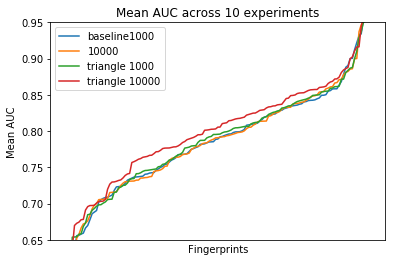

In [14]:
plt.title("Mean AUC across 10 experiments")
plt.plot(range(0, len(auc_mean_scores_baseline_1000)), auc_mean_scores_baseline_1000, label="baseline1000")
plt.plot(range(0, len(auc_mean_scores_10000)), auc_mean_scores_10000, label="10000")
plt.plot(range(0, len(auc_mean_scores_1000_triangle)), auc_mean_scores_1000_triangle, label="triangle 1000")
plt.plot(range(0, len(auc_mean_scores_10000_triangle)), auc_mean_scores_10000_triangle, label="triangle 10000")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylim(0.65, 0.95)
plt.ylabel("Mean AUC")
plt.show()

In [15]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest",
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
   
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used",
        new_values.append((fingerprint, pvalue, rank, critical_value))
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    return new_values, max_pvalue_less_than_crit_rank

In [16]:
fingerprint_names = load_fingerprint_legend()

Compare 10000 to baseline 1000

In [17]:
pvalues = []
differences = []
z_differences = []

f1_pvalues = []
f1_differences = []
f1_z_differences = []
    
base_mean_aucs = []
exp_mean_aucs = []

for i in auc_10000_df.columns:
    # AUC
    base_aucs = auc_baseline_1000_df[i]
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = auc_10000_df[i]
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)

    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    
    difference = [difference for difference in (exp_aucs-base_aucs).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0

    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))
    
    # F1
    base_f1s = f1_baseline_1000_df[i]
    base_f1_mean = statistics.mean(base_f1s)
    base_f1_std = statistics.stdev(base_f1s)
    
    exp_f1s = f1_1000_triangle_df[i]
    exp_f1_mean = statistics.mean(exp_f1s)
    exp_f1_std = statistics.stdev(exp_f1s)
    
    difference = [difference for difference in (exp_f1s-base_f1s).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    f1_z_score = 0.0
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        f1_z_score = float(exp_f1_mean - base_f1_mean)/(((exp_f1_std**2) + (base_f1_std**2))**(float(1)/2))

    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, f1_z_score))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    
    if math.isnan(t_test.pvalue):
        f1_pvalues.append((i, 1.0))
    else:
        f1_pvalues.append((i, t_test.pvalue))

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:2413: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [18]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))

z_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
f1_differences.reverse()
z_differences.reverse()
f1_z_differences.reverse()

In [19]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [20]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]
base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]
std_err = [fingerprint[2] for fingerprint in differences]

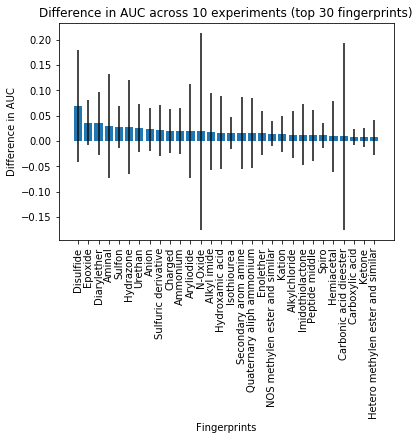

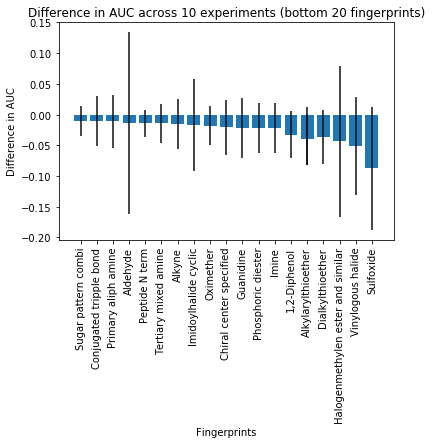

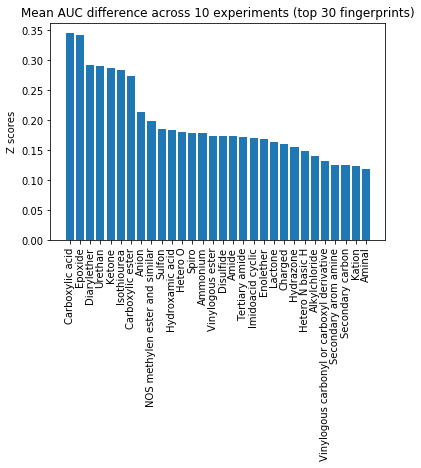

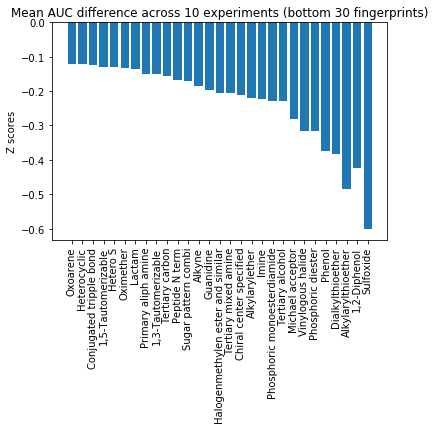

0 significantly different mean aucs
0 significantly positive difference
0 significantly negative difference


In [21]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

In [22]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [23]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]
f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

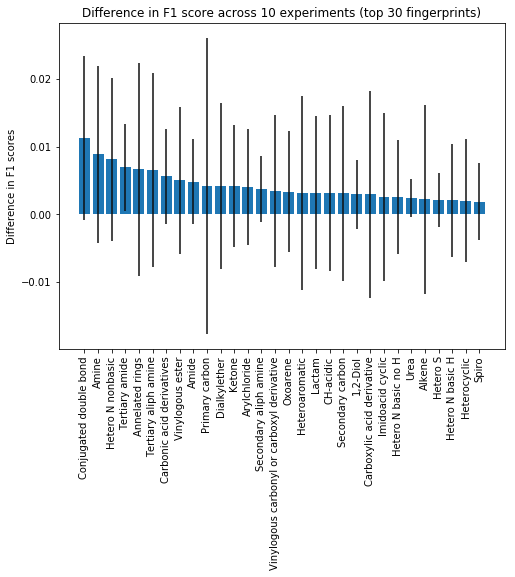

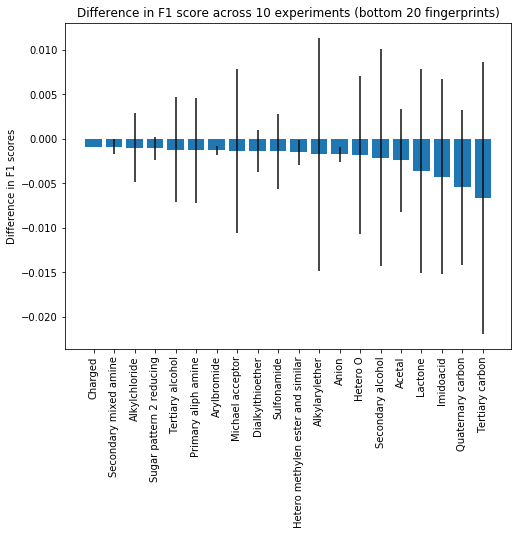

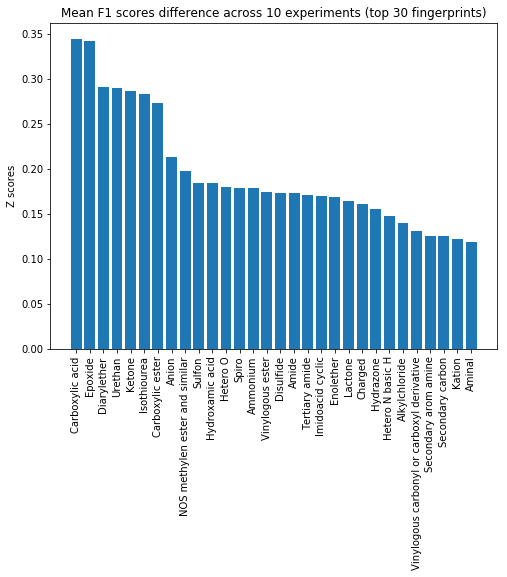

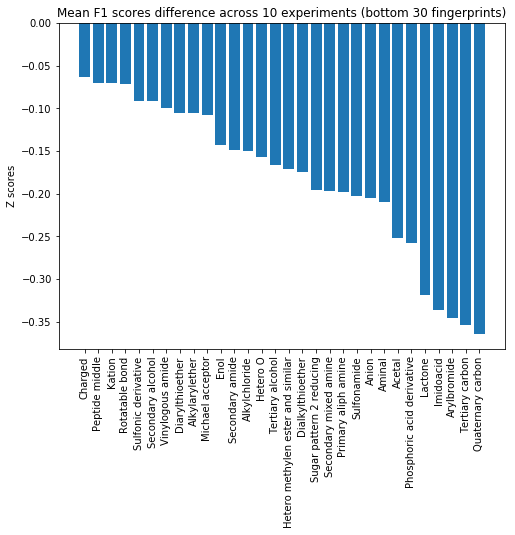

0 significantly different mean f1 scores
0 significantly positive difference
0 significantly negative difference


In [24]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[119:], f1_score_differences[119:], align='center', yerr=f1_std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare triangle 10000 to baseline 1000

In [25]:
pvalues = []
differences = []
z_differences = []

f1_pvalues = []
f1_differences = []
f1_z_differences = []
    
base_mean_aucs = []
exp_mean_aucs = []

for i in auc_10000_triangle_df.columns:
    # AUC
    base_aucs = auc_baseline_1000_df[i]
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = auc_10000_triangle_df[i]
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)

    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    
    difference = [difference for difference in (exp_aucs-base_aucs).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0

    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))
    
    # F1
    base_f1s = f1_baseline_1000_df[i]
    base_f1_mean = statistics.mean(base_f1s)
    base_f1_std = statistics.stdev(base_f1s)
    
    exp_f1s = f1_1000_triangle_df[i]
    exp_f1_mean = statistics.mean(exp_f1s)
    exp_f1_std = statistics.stdev(exp_f1s)
    
    difference = [difference for difference in (exp_f1s-base_f1s).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    f1_z_score = 0.0
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        f1_z_score = float(exp_f1_mean - base_f1_mean)/(((exp_f1_std**2) + (base_f1_std**2))**(float(1)/2))

    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, f1_z_score))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    
    if math.isnan(t_test.pvalue):
        f1_pvalues.append((i, 1.0))
    else:
        f1_pvalues.append((i, t_test.pvalue))

In [26]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))

z_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
f1_differences.reverse()
z_differences.reverse()
f1_z_differences.reverse()

In [27]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [28]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]
base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]
std_err = [fingerprint[2] for fingerprint in differences]

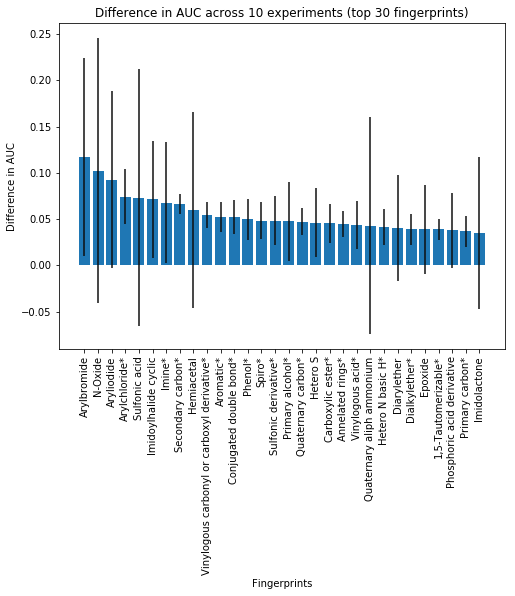

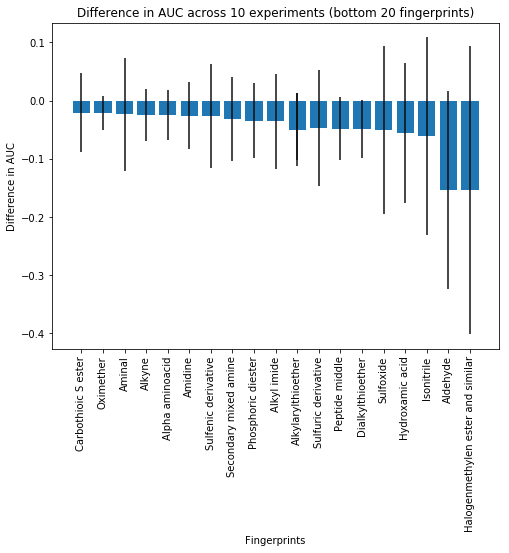

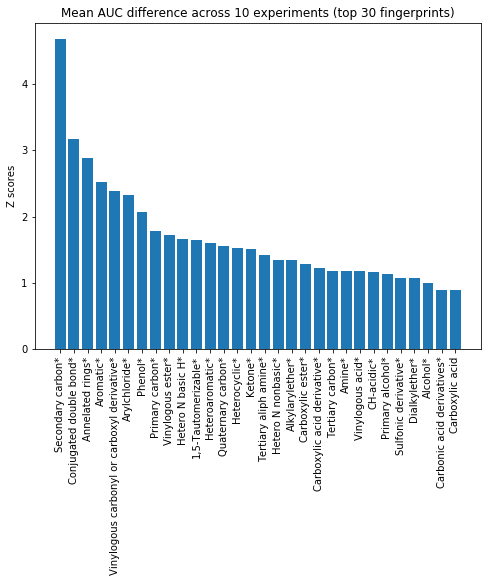

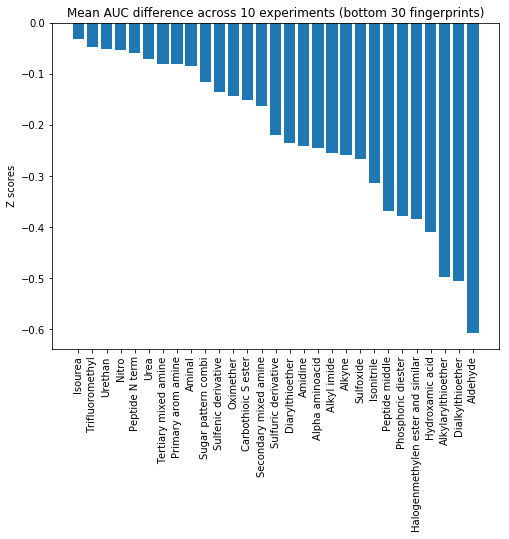

35 significantly different mean aucs
35 significantly positive difference
0 significantly negative difference


In [29]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

In [30]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [31]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]
f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

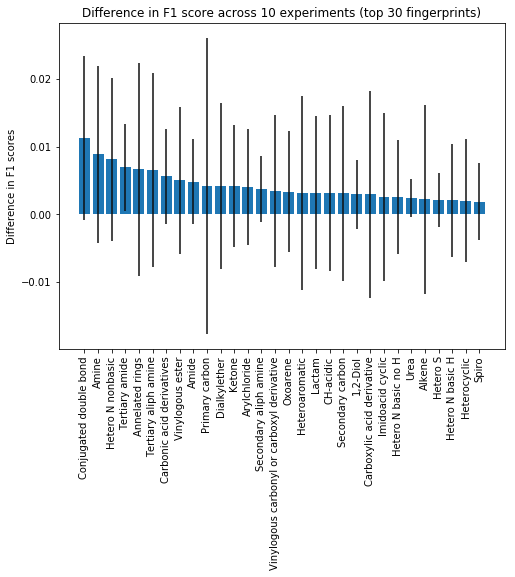

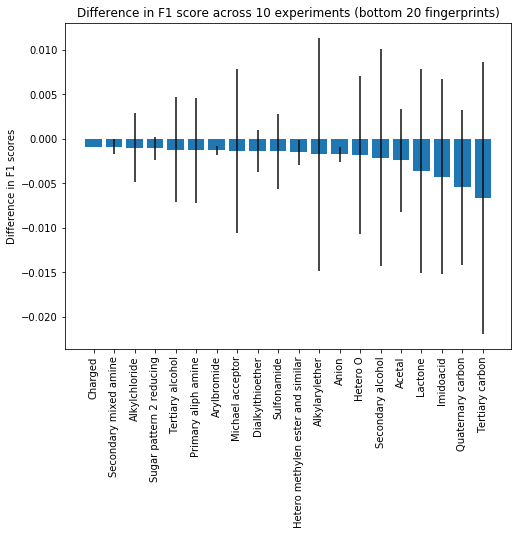

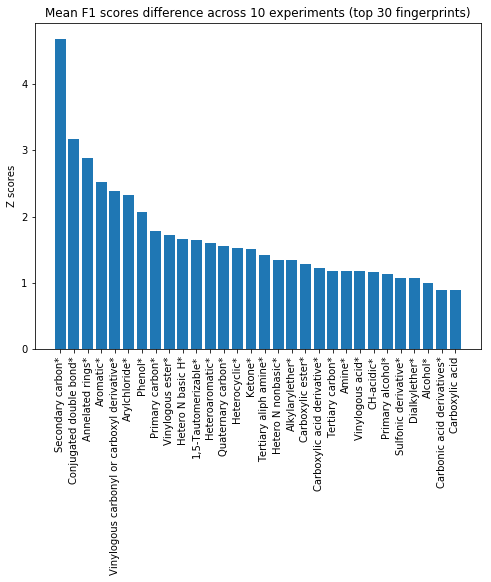

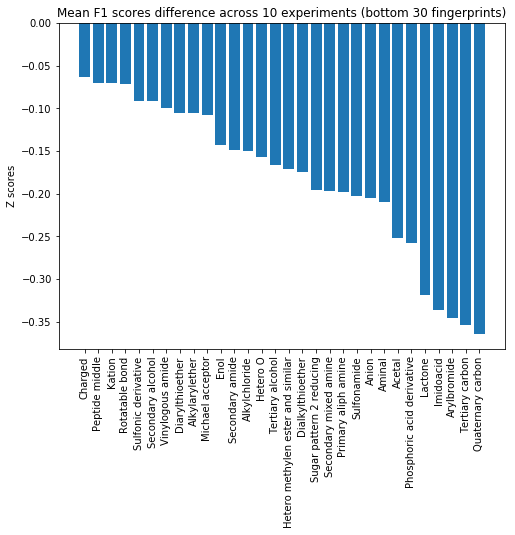

0 significantly different mean f1 scores
0 significantly positive difference
0 significantly negative difference


In [32]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[119:], f1_score_differences[119:], align='center', yerr=f1_std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare 1000 triangle to baseline

In [195]:
pvalues = []
differences = []
z_differences = []

f1_pvalues = []
f1_differences = []
f1_z_differences = []
    
base_mean_aucs = []
exp_mean_aucs = []

for i in auc_1000_triangle_df.columns:
    # AUC
    base_aucs = auc_baseline_1000_df[i]
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = auc_1000_triangle_df[i]
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)

    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    
    difference = [difference for difference in (exp_aucs-base_aucs).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0

    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))
    
    # F1
    base_f1s = f1_baseline_1000_df[i]
    base_f1_mean = statistics.mean(base_f1s)
    base_f1_std = statistics.stdev(base_f1s)
    
    exp_f1s = f1_1000_triangle_df[i]
    exp_f1_mean = statistics.mean(exp_f1s)
    exp_f1_std = statistics.stdev(exp_f1s)
    
    difference = [difference for difference in (exp_f1s-base_f1s).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    f1_z_score = 0.0
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        f1_z_score = float(exp_f1_mean - base_f1_mean)/(((exp_f1_std**2) + (base_f1_std**2))**(float(1)/2))

    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, f1_z_score))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    
    if math.isnan(t_test.pvalue):
        f1_pvalues.append((i, 1.0))
    else:
        f1_pvalues.append((i, t_test.pvalue))

In [180]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))

z_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
f1_differences.reverse()
z_differences.reverse()
f1_z_differences.reverse()

In [181]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [182]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]
base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]
std_err = [fingerprint[2] for fingerprint in differences]

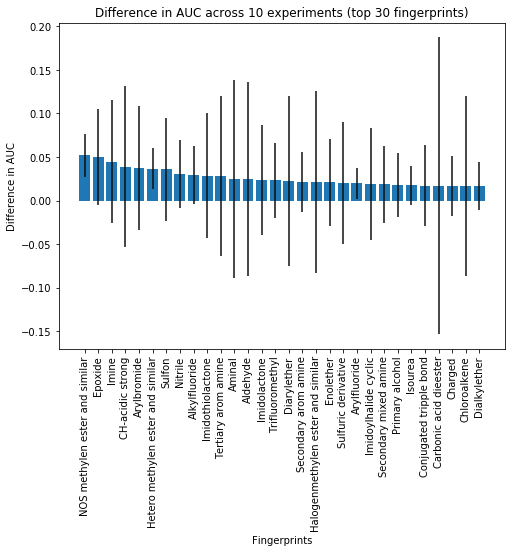

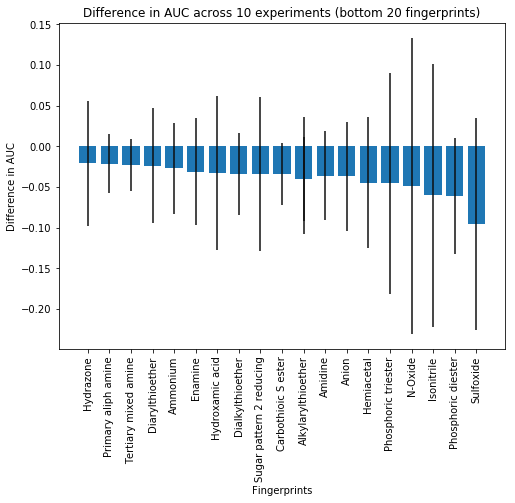

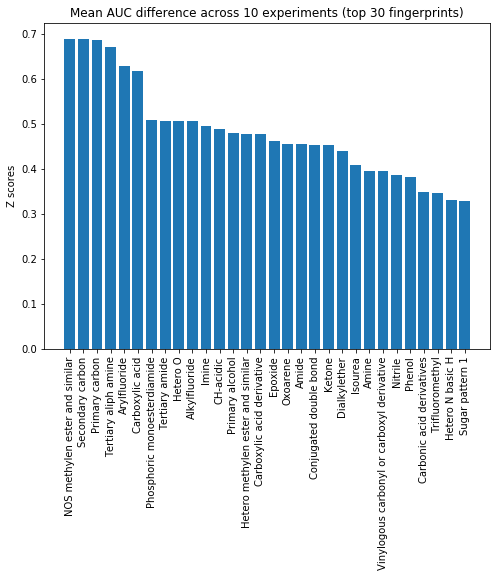

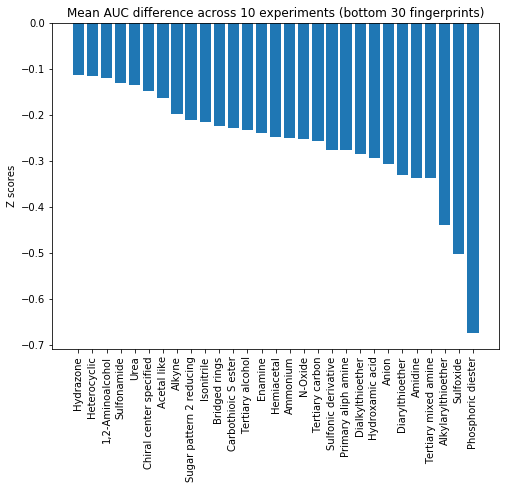

0 significantly different mean aucs
0 significantly positive difference
0 significantly negative difference


In [183]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

In [184]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [185]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]
f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

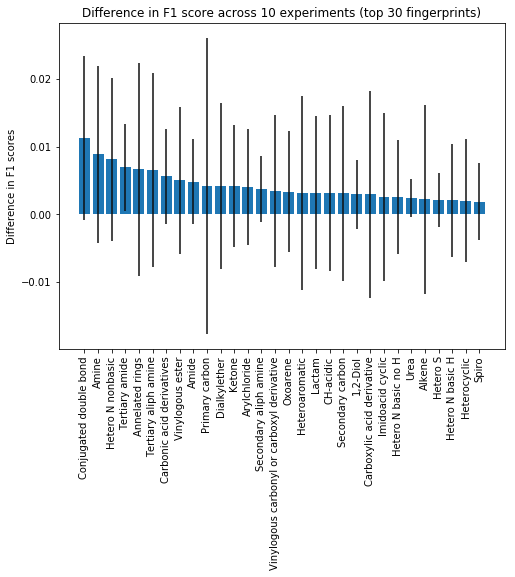

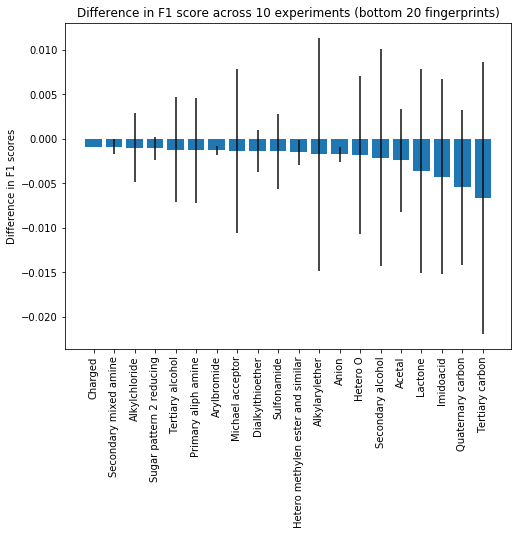

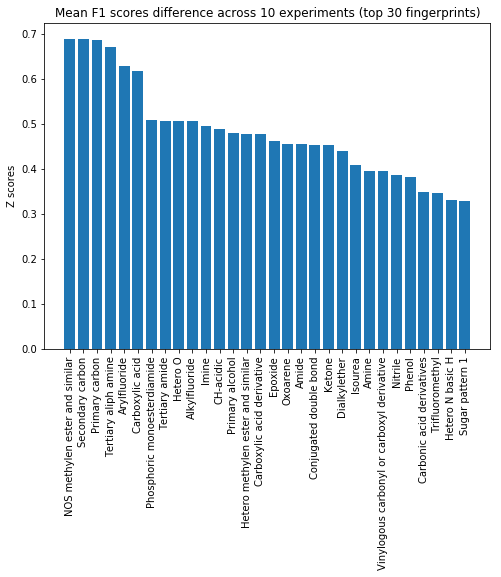

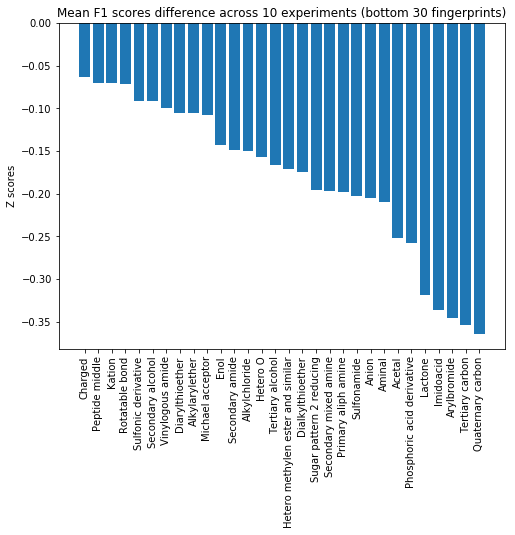

0 significantly different mean f1 scores
0 significantly positive difference
0 significantly negative difference


In [186]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[119:], f1_score_differences[119:], align='center', yerr=f1_std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare 10000 triangle to 1000 triangle

In [204]:
pvalues = []
differences = []
z_differences = []

f1_pvalues = []
f1_differences = []
f1_z_differences = []
    
base_mean_aucs = []
exp_mean_aucs = []

for i in auc_1000_triangle_df.columns:
    # AUC
    base_aucs = auc_1000_triangle_df[i]
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = auc_10000_triangle_df[i]
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)

    base_mean_aucs.append((i, base_mean))
    exp_mean_aucs.append((i, exp_mean))
    
    difference = [difference for difference in (exp_aucs-base_aucs).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0

    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
        
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = stats.wilcoxon(base_aucs, exp_aucs)
    pvalues.append((i, t_test.pvalue))
    
    # F1
    base_f1s = f1_1000_triangle_df[i]
    base_f1_mean = statistics.mean(base_f1s)
    base_f1_std = statistics.stdev(base_f1s)
    
    exp_f1s = f1_10000_triangle_df[i]
    exp_f1_mean = statistics.mean(exp_f1s)
    exp_f1_std = statistics.stdev(exp_f1s)
    
    difference = [difference for difference in (exp_f1s-base_f1s).tolist() if difference != 0] # remove outliers
    difference_std = 0.0
    difference_mean = 0.0
    f1_z_score = 0.0
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        f1_z_score = float(exp_f1_mean - base_f1_mean)/(((exp_f1_std**2) + (base_f1_std**2))**(float(1)/2))

    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, f1_z_score))
    t_test = stats.wilcoxon(base_f1s, exp_f1s)
    if math.isnan(t_test.pvalue):
        f1_pvalues.append((i, 1.0))
    else:
        f1_pvalues.append((i, t_test.pvalue))

In [205]:
differences.sort(key=lambda x: float(x[1]))
f1_differences.sort(key=lambda x: float(x[1]))

z_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

base_mean_aucs.sort(key=lambda x: float(x[1]))
exp_mean_aucs.sort(key=lambda x: float(x[1]))

differences.reverse()
f1_differences.reverse()
z_differences.reverse()
f1_z_differences.reverse()

In [206]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [207]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]
base_mean_auc_scores = [fingerprint[1] for fingerprint in base_mean_aucs]
exp_mean_auc_scores = [fingerprint[1] for fingerprint in exp_mean_aucs]
score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]
std_err = [fingerprint[2] for fingerprint in differences]

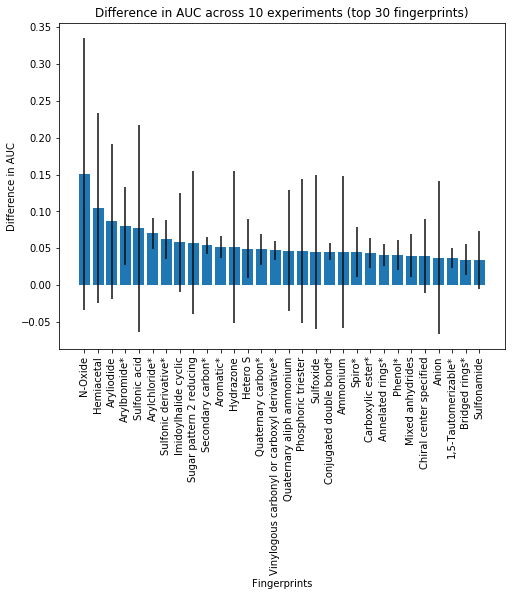

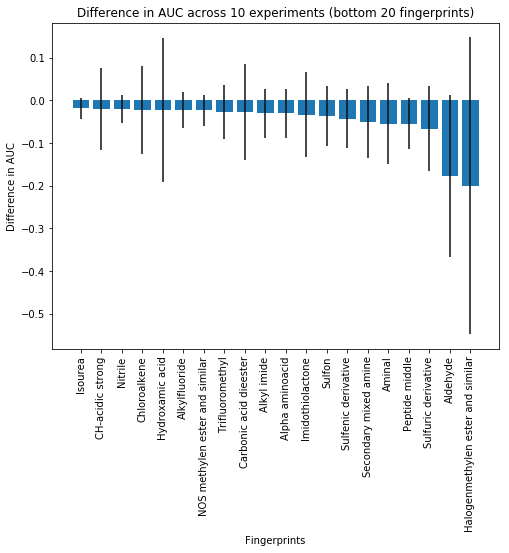

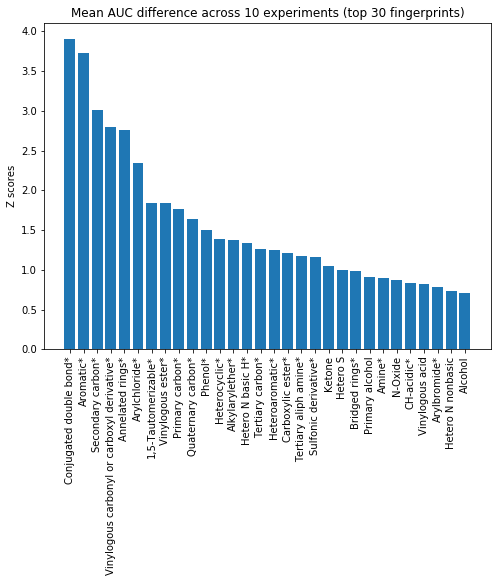

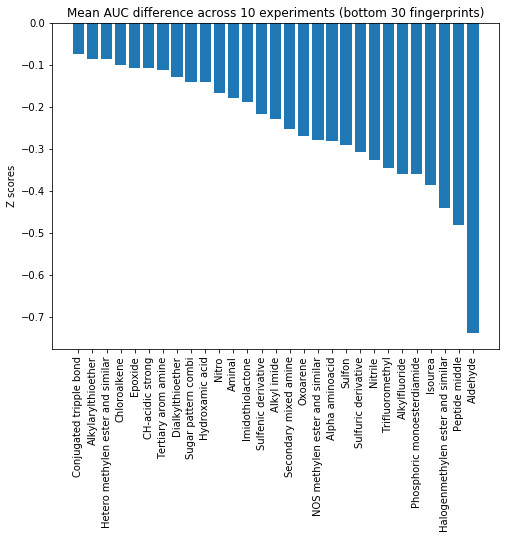

26 significantly different mean aucs
26 significantly positive difference
0 significantly negative difference


In [208]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (top 30 fingerprints)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Difference in AUC across 10 experiments (bottom 20 fingerprints)")
plt.bar(fingerprints[119:], score_differences[119:], align='center', yerr=std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC")
plt.show()

plt.title("Mean AUC difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean AUC difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(z_fingerprints[109:], z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

In [209]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [210]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]
f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

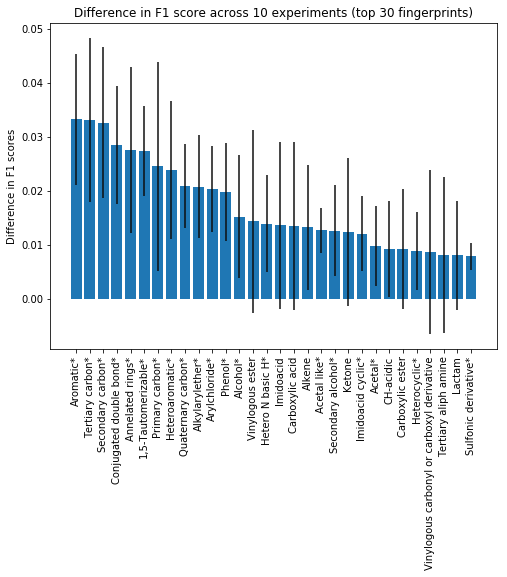

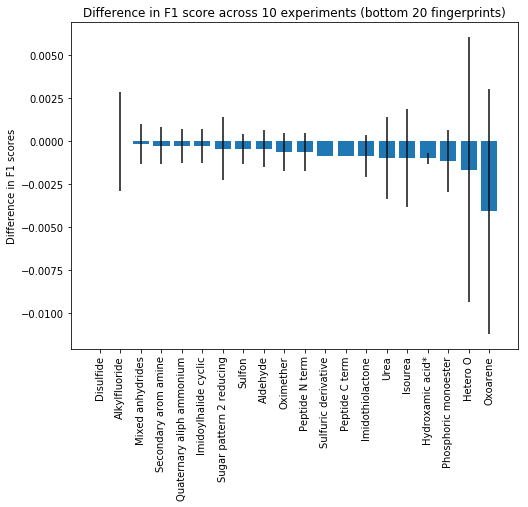

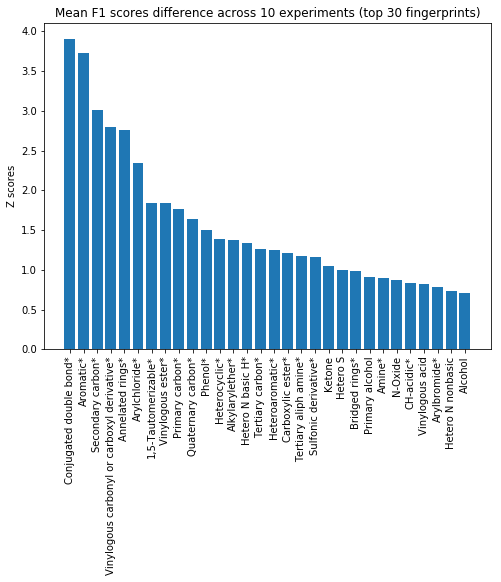

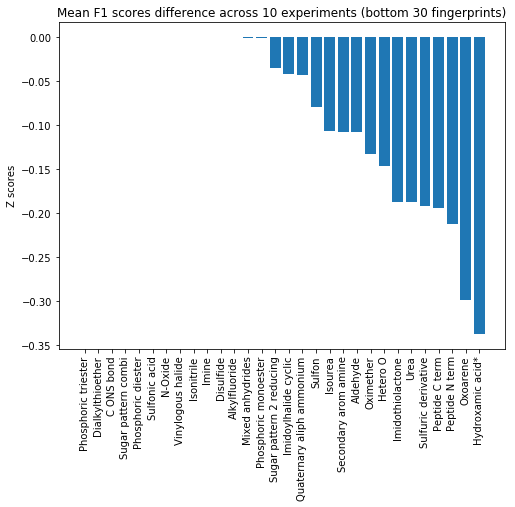

36 significantly different mean f1 scores
35 significantly positive difference
1 significantly negative difference


In [211]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (top 30 fingerprints)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Difference in F1 score across 10 experiments (bottom 20 fingerprints)")
plt.bar(f1_fingerprints[119:], f1_score_differences[119:], align='center', yerr=f1_std_err[119:], error_kw=error_config)
plt.xticks(rotation=90)
plt.ylabel("Difference in F1 scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (top 30 fingerprints)")
plt.bar(z_fingerprints[:30], z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

plt.title("Mean F1 scores difference across 10 experiments (bottom 30 fingerprints)")
plt.bar(f1_z_fingerprints[109:], f1_z_scores[109:], align='center')
plt.xticks(rotation=90)
plt.ylabel("Z scores")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))